#**Práctica IA - Manuel Saravia Enrech, INSO4Z**


El dataset elegido nos da informacion sobre los futbolistas que aparecen en el videojuego FIFA 20. Incluye  variables numéricas como caracteristicas o sueldo, y variables categóricas como el club o la nacionalidad. El dataset contiene más de 18 mil registros (futbolistas) con más de 100 variables cada uno. <br>
El objetivo es hacer predicciones sobre la variable precio del jugador usando un subconjunto de variables significativas del dataset. <br>
Considero que es una propuesta interesante para el mundo de los datos aplicado al negocio del deporte profesional. El uso del machine learning o la inteligencia artificial en este campo es cada día más demandado. <br>
Poder estimar el precio de mercado de un jugador o bien al menos poder categorizar su rango de precio es muy relevante para la actividad de compraventa de jugadores, no solo para clubes de fútbol sino que también en muchos casos son objeto de inversión por parte de fondos que adquieren los derechos (o un porcentaje) de jugadores. 


# **Parte 1 - Modelo de regresión.**

El objetivo es estimar la variable precio del futbolista con vistas a una posible transacción de compraventa.

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## PASO 1: Carga del dataset

In [322]:
# Uso Google Colab notebooks y mi unidad Drive para ubicar el dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [323]:
# carga del dataset en un Dataframe panda, y primer vistazo a los datos
df = pd.read_csv('/content/drive/My Drive/data/players_20.csv', sep = ",")
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


Vemos que el dataset contiene más de 18 mil observaciones y 104 variables

In [324]:
df.shape

(18278, 104)

## PASO 2: Exploracion y Preparacion de los datos

### Exploración preliminar de los datos

In [325]:
# info básica del dataframe. Demasiadas variables para mostrar 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Columns: 104 entries, sofifa_id to rb
dtypes: float64(16), int64(45), object(43)
memory usage: 14.5+ MB


In [326]:
# Listado de variables y su tipo
[(i, col, df[col].dtype) for i, col in enumerate(df.columns)]

[(0, 'sofifa_id', dtype('int64')),
 (1, 'player_url', dtype('O')),
 (2, 'short_name', dtype('O')),
 (3, 'long_name', dtype('O')),
 (4, 'age', dtype('int64')),
 (5, 'dob', dtype('O')),
 (6, 'height_cm', dtype('int64')),
 (7, 'weight_kg', dtype('int64')),
 (8, 'nationality', dtype('O')),
 (9, 'club', dtype('O')),
 (10, 'overall', dtype('int64')),
 (11, 'potential', dtype('int64')),
 (12, 'value_eur', dtype('int64')),
 (13, 'wage_eur', dtype('int64')),
 (14, 'player_positions', dtype('O')),
 (15, 'preferred_foot', dtype('O')),
 (16, 'international_reputation', dtype('int64')),
 (17, 'weak_foot', dtype('int64')),
 (18, 'skill_moves', dtype('int64')),
 (19, 'work_rate', dtype('O')),
 (20, 'body_type', dtype('O')),
 (21, 'real_face', dtype('O')),
 (22, 'release_clause_eur', dtype('float64')),
 (23, 'player_tags', dtype('O')),
 (24, 'team_position', dtype('O')),
 (25, 'team_jersey_number', dtype('float64')),
 (26, 'loaned_from', dtype('O')),
 (27, 'joined', dtype('O')),
 (28, 'contract_valid_

In [327]:
# Resumen estadístico (variables numéricas)
df.describe()

,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,1.827800e+04,18278.000000,18278.000000,18278.000000,18278.000000,1.698000e+04,18038.000000,18038.000000,1126.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000
mean,219738.864482,25.283291,181.362184,75.276343,66.244994,71.546887,2.484038e+06,9456.942773,1.103184,2.944250,2.368038,4.740717e+06,20.103892,2021.114591,12.114565,67.700899,52.298301,57.233777,62.531585,51.553503,64.876678,65.422397,63.146365,61.832515,66.390472,37.798625,63.374754,49.718405,45.590218,52.221468,58.748003,42.809388,55.596509,47.325692,42.708885,52.768848,58.461976,64.299923,64.415746,63.504924,61.752544,63.856439,58.181694,64.928165,62.889485,65.234763,46.812945,55.742149,46.380239,50.072163,53.609749,48.383357,58.528778,46.848889,47.640333,45.606631,16.572765,16.354853,16.212934,16.368038,16.709924
std,27960.200461,4.656964,6.756961,7.047744,6.949953,6.139669,5.585481e+06,21351.714095,0.378861,0.664656,0.765038,1.103002e+07,16.603639,1.289888,6.735922,11.297656,14.029418,10.407844,10.284950,16.419528,9.760162,7.736278,7.244023,7.510709,8.154062,10.634038,8.447876,18.325403,19.594609,17.428429,14.679653,17.701815,18.929118,18.422991,17.433612,15.246454,16.741878,15.042232,14.847763,14.808380,9.135613,14.201559,13.326083,11.934059,16.017954,12.534811,19.322343,17.318157,20.775812,19.594022,13.955626,15.708099,11.880840,20.091287,21.585641,21.217734,17.738069,16.996925,16.613665,17.136497,18.038125
min,768.000000,16.000000,156.000000,50.000000,48.000000,49.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.300000e+04,1.000000,2019.000000,1.000000,24.000000,15.000000,24.000000,23.000000,15.000000,27.000000,44.000000,42.000000,35.000000,45.000000,12.000000,41.000000,5.000000,2.000000,5.000000,7.000000,3.000000,4.000000,6.000000,4.000000,8.000000,5.000000,12.000000,11.000000,11.000000,21.000000,12.000000,14.000000,19.000000,12.000000,20.000000,4.000000,9.000000,3.000000,2.000000,9.000000,7.000000,12.000000,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,204445.500000,22.000000,177.000000,70.000000,62.000000,67.000000,3.250000e+05,1000.000000,1.000000,3.000000,2.000000,5.630000e+05,9.000000,2020.000000,6.000000,61.000000,42.000000,50.000000,57.000000,36.000000,59.000000,60.000000,58.000000,57.000000,60.750000,29.000000,58.000000,38.000000,30.000000,44.000000,54.000000,30.000000,50.000000,34.000000,31.000000,43.000000,54.000000,56.000000,57.

### La mayoría de las variables no son relevantes para la estimación del precio de mercado de un futbolista.
 Consideraremos inicialmente las siguientes variables:
 - value_eur (precio del jugador en euros) -> variable target
 - age  (edad)
 - overall (valoración global del jugador 1-100)
 - potential (valoración global que se cree que un jugador podría alcanzar 1-100)
 - preferred_foot (diestro o zurdo)
 - international_reputation (valor de 1-5)
 - team_position (29 valores posibles)
 - wage_eur (salario del jugador en euros)
 
 Generamos un **nuevo dataset df_fifa con solo estas variables**.
- Cambiaremos las variables value_eur a millones de euros (M€)
- Cambiaremos la wage_eur a miles de euros (K€)
- cambiaremos la variable preferred_foot a numérica (0-1)
- cambiaremos la variable team_position a numérica (0-28)

**NOTA**: no usaremos la variable release_clause_eur porque tiene una correlación total con el target value_err y el modelo sería demasiado simple. 


In [328]:
vars_selected = ['short_name', 'overall', 'age','potential', 'preferred_foot', 'international_reputation', 'team_position', 'wage_eur', 'value_eur']
df_fifa = df[vars_selected]


In [329]:
df_fifa['value_eur'] = df_fifa['value_eur'] / 1000000
df_fifa['wage_eur'] = df_fifa['wage_eur'] / 1000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [330]:
df_fifa['preferred_foot'] = df_fifa['preferred_foot'].replace(['Right', 'Left'], [0, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [331]:
# Ordenamos team_position según el value_eur medio asociado a cada posición antes del replace
teampos_sort = df_fifa[['team_position', 'value_eur']].groupby('team_position', as_index=False)['value_eur'].mean().sort_values(by='value_eur')
lpos = list(teampos_sort['team_position'])
ipos = list(range(len(lpos)))
df_fifa['team_position'] = df_fifa['team_position'].replace(lpos, ipos)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [332]:
df_fifa.head()

,short_name,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur,value_eur
0,L. Messi,94,32,94,1,5,27.0,565.0,95.5
1,Cristiano Ronaldo,93,34,93,0,5,26.0,405.0,58.5
2,Neymar Jr,92,27,92,0,5,20.0,290.0,105.5
3,J. Oblak,91,26,93,0,3,12.0,125.0,77.5
4,E. Hazard,91,28,91,0,4,26.0,470.0,90.0


In [333]:
df_fifa.describe()

,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur,value_eur
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18038.000000,18278.000000,18278.000000
mean,66.244994,25.283291,71.546887,0.236240,1.103184,5.473500,9.456943,2.484038
std,6.949953,4.656964,6.139669,0.424783,0.378861,6.922731,21.351714,5.585481
min,48.000000,16.000000,49.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,22.000000,67.000000,0.000000,1.000000,1.000000,1.000000,0.325000
50%,66.000000,25.000000,71.000000,0.000000,1.000000,1.000000,3.000000,0.700000
75%,71.000000,29.000000,75.000000,0.000000,1.000000,10.000000,8.000000,2.100000
max,94.000000,42.000000,95.000000,1.000000,5.000000,28.000000,565.000000,105.500000


### Comprobamos y resolvemos posibles valores ausentes en estas variables antes de continuar.

In [334]:
df_fifa.isnull().any()


short_name                  False
overall                     False
age                         False
potential                   False
preferred_foot              False
international_reputation    False
team_position                True
wage_eur                    False
value_eur                   False
dtype: bool

In [335]:
df_fifa.loc[df_fifa['team_position'].isnull()].shape

(240, 9)

Decidimos eliminar los registros con valores NaN en team_position. Son muy pocos comparados con el total. 

In [336]:
df_fifa.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [337]:
df_fifa.shape

(18038, 9)

In [338]:
# team_position as int
df_fifa['team_position'] = df_fifa['team_position'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [339]:
df_fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18038 entries, 0 to 18277
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   short_name                18038 non-null  object 
 1   overall                   18038 non-null  int64  
 2   age                       18038 non-null  int64  
 3   potential                 18038 non-null  int64  
 4   preferred_foot            18038 non-null  int64  
 5   international_reputation  18038 non-null  int64  
 6   team_position             18038 non-null  int64  
 7   wage_eur                  18038 non-null  float64
 8   value_eur                 18038 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 1.4+ MB


### Visualización de datos. Nos permitirá conocer de un vistazo el comportamiento de las distintas variables y su relación especialmente con la variable target (value_eur = precio del jugador).

#### Primero vamos a visualizar el histograma de las principales variables que vamos a usar en los modelos para ver cómo se distribuyen

Histogramas de las variables value_eur, overall, wage_eur, team_position

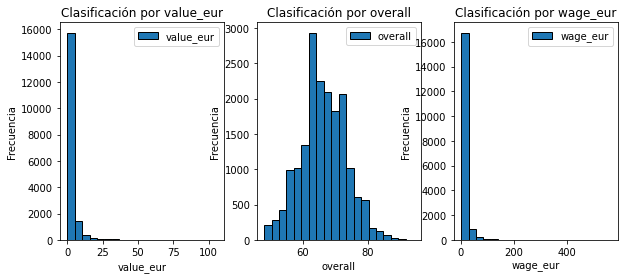

In [340]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows= 1,ncols = 3, figsize=(10,4)) 

ax1.hist(df_fifa.value_eur, label = ['value_eur'], edgecolor='black', bins=20)  
ax1.legend(loc=0)
ax1.set_title('Clasificación por value_eur')
ax1.set_xlabel('value_eur')
ax1.set_ylabel('Frecuencia')

ax2.hist(df_fifa.overall, label = ['overall'], edgecolor='black', bins=20)  
ax2.legend(loc=0)
ax2.set_title('Clasificación por overall')
ax2.set_xlabel('overall')
ax2.set_ylabel('Frecuencia')

ax3.hist(df_fifa.wage_eur, label = ['wage_eur'], edgecolor='black', bins=20)  
ax3.legend(loc=0)
ax3.set_title('Clasificación por wage_eur')
ax3.set_xlabel('wage_eur')
ax3.set_ylabel('Frecuencia')

None



Se ve que la variable wage_eur tiene una distribución similar a value_eur

Histogramas de las variables age, potential, preferred_foot international_reputation, 

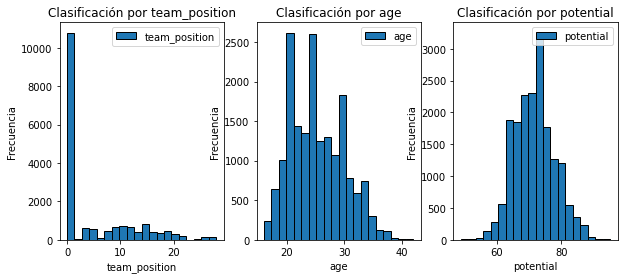

In [341]:
fig, (ax4, ax5, ax6) = plt.subplots(nrows= 1,ncols = 3, figsize=(10,4)) 

ax4.hist(df_fifa.team_position, label = ['team_position'], edgecolor='black', bins=20)  
ax4.legend(loc=0)
ax4.set_title('Clasificación por team_position')
ax4.set_xlabel('team_position')
ax4.set_ylabel('Frecuencia')

ax5.hist(df_fifa.age, label = ['age'], edgecolor='black', bins=20)  
ax5.legend(loc=0)
ax5.set_title('Clasificación por age')
ax5.set_xlabel('age')
ax5.set_ylabel('Frecuencia')

ax6.hist(df_fifa.potential, label = ['potential'], edgecolor='black', bins=20)  
ax6.legend(loc=0)
ax6.set_title('Clasificación por potential')
ax6.set_xlabel('potential')
ax6.set_ylabel('Frecuencia')

None

Se ve que la variable potential tiene una distribución similar a overall

#### Gráfico de dispersión de la variable value_eur, que es la variable Y, con respecto a las variables  wage_eur, team_position, overall y potential.

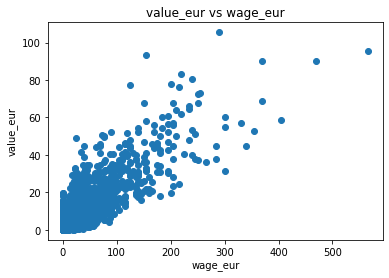

In [342]:
plot = plt.scatter(df_fifa.wage_eur, df_fifa.value_eur)
plt.xlabel('wage_eur')
plt.ylabel('value_eur')
plt.title('value_eur vs wage_eur')
plt.show()

Se ve la correlacion positiva existente.

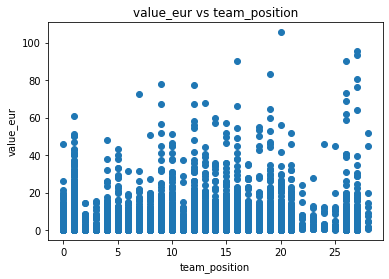

In [343]:
plot = plt.scatter(df_fifa.team_position, df_fifa.value_eur)
plt.xlabel('team_position')
plt.ylabel('value_eur')
plt.title('value_eur vs team_position')
plt.show()

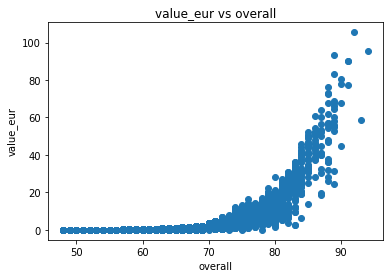

In [344]:
plot = plt.scatter(df_fifa.overall, df_fifa.value_eur)
plt.xlabel('overall')
plt.ylabel('value_eur')
plt.title('value_eur vs overall')
plt.show()

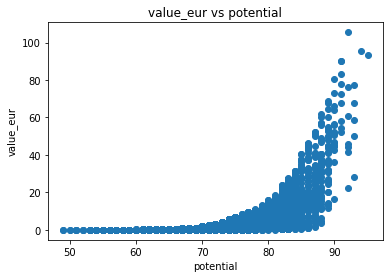

In [345]:
plot = plt.scatter(df_fifa.potential, df_fifa.value_eur)
plt.xlabel('potential')
plt.ylabel('value_eur')
plt.title('value_eur vs potential')
plt.show()

Se observa cómo  valores de overall o potential menores que 70 no tienen prácticamente impacto en el precio del jugador. **Por tanto, vamos a centrarnos en los jugadores cuyo overall y potential es mayor o igual a 70.** Son los jugadores que nos pueden interesar con vistas a posible traspasos. Quedan más de 5.500. 

In [346]:
df_fifa = df_fifa[(df_fifa['overall'] >= 70) & (df_fifa['potential'] >= 70)]
df_fifa.shape

(5542, 9)

#### Correlación entre las variables

In [347]:
import seaborn as sns

Matriz de correlación:

In [348]:
corr = df_fifa.corr()
corr

,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur,value_eur
overall,1.000000,0.046700,0.722616,-0.002887,0.639942,0.144606,0.723950,0.846558
age,0.046700,1.000000,-0.535219,-0.040650,0.280411,0.061815,-0.005481,-0.179240
potential,0.722616,-0.535219,1.000000,0.004628,0.335178,0.065827,0.530500,0.724903
preferred_foot,-0.002887,-0.040650,0.004628,1.000000,-0.016607,-0.016132,0.012907,0.012557
international_reputation,0.639942,0.280411,0.335178,-0.016607,1.000000,0.067684,0.597067,0.545712
team_position,0.144606,0.061815,0.065827,-0.016132,0.067684,1.000000,0.035516,0.159200
wage_eur,0.723950,-0.005481,0.530500,0.012907,0.597067,0.035516,1.000000,0.816117
value_eur,0.846558,-0.179240,0.724903,0.012557,0.545712,0.159200,0.816117,1.000000


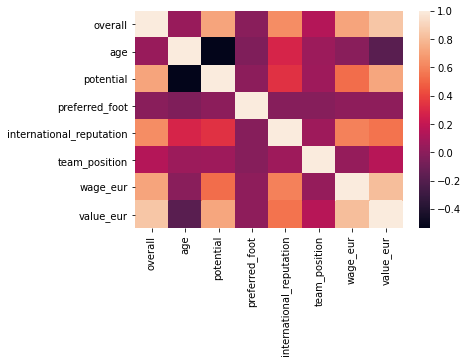

In [349]:
sns.heatmap(corr)

Se muestra la correlación entre las distintas variables, y fijándonos en la variable target value_eur se observa una correlación alta con con overall, wage_eur y potential, media-alta con international_reputation, baja con age y team_position y casi nula con preferred_foot. Se observa como la correlación con age es negativa (a partir de una edad cuanto mayor sea un jugador su precio descenderá)

## PASO 3: Creación y Entrenamiento del Modelo (Regresión Lineal Múltiple)

In [350]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [351]:
# Creating Predictor variable 'X' and Target Variable 'Y'
# X contains all the features except for the target value_eur and short_name
X = df_fifa.drop(['short_name', 'value_eur'], axis = 1)
Y = df_fifa['value_eur']

In [352]:
print(X.shape)
print(Y.shape)

(5542, 7)
(5542,)


In [353]:
# Cogemos 70% datos para train y 30% para test. Fijo una semilla para poder reproducir.
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.3,
                                                    random_state=0)

print(X_train.shape)
print(X_test.shape)

(3879, 7)
(1663, 7)


In [354]:
X_train.head()

,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur
4514,71,36,71,0,1,12,5.0
5597,70,29,70,1,1,5,6.0
774,78,22,84,0,2,9,24.0
1723,75,24,80,0,1,4,21.0
1052,77,23,82,0,2,15,45.0


In [355]:
linear_reg = LinearRegression()
# Train/fit the model to training data
linear_reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## PASO 4: Evaluar el rendimiento del modelo

In [356]:
# print the intercept
print(linear_reg.intercept_)

# Coefficients
coeff_df = pd.DataFrame(linear_reg.coef_,
                        X.columns,
                        columns=['Coefficient'])
coeff_df

-73.95287957326283


,Coefficient
overall,1.291167
age,-0.493476
potential,-0.062167
preferred_foot,-0.067497
international_reputation,0.084379
team_position,0.087770
wage_eur,0.106988


Interpretando los coeficientes:
como ejemplo, manteniendo fijos los valores de las otras variables, un incremento de 1 en overall se traduce en un aumento de 1,29 millones de euros en value_eur (precio del jugador) 


**Predicciones del Modelo**

In [357]:
pred = linear_reg.predict(X_test)

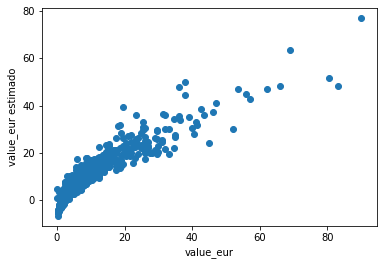

In [358]:
plt.scatter(Y_test, pred)
plt.xlabel("value_eur")
plt.ylabel("value_eur estimado")
None

Se observa que hay una tendencia a una línea recta de pendiente casi 1, lo cual muestra que la predicción es razonablemente buena.

**Métricas de Evaluación**
<br>
Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE)

In [359]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix

In [360]:
print('Mean Absolute Error (MAE):', mean_absolute_error(Y_test, pred))
print('Mean Squared Error (MSE):', mean_squared_error(Y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(Y_test, pred)))

Mean Absolute Error (MAE): 1.9798964066356564
Mean Squared Error (MSE): 9.521697392866079
Root Mean Squared Error (RMSE): 3.0857247759426114


In [361]:
df_fifa.value_eur.mean()

6.963336340671266

Comentamos por ejemplo la métrica MAE: el error absoluto medio es de casi 2M€. Si lo comparamos con la media de value_eur que es 7M€ podemos concluir que el error es significativo pero no demasiado alto.

In [362]:
r2 = r2_score(Y_test, pred)
r2

0.8564321749611044

Un valor bueno para R cuadrado, con lo cual podemos afirmar que nuestro modelo se ajusta razonablemente. El 85.6% de la variación de la variable dependiente (value_eur = precio del jugador) es explicada por el modelo.

In [363]:
from scipy import stats

pearson_coef, p_value = stats.pearsonr(Y_test, pred)
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value)

Pearson Correlation Coefficient:  0.9270188270219331 and a P-value of: 0.0


Se confirma que el modelo es adecuado con el coeficiente de correlación de Pearson de 0.93 y P-value = 0

## PASO 5: Mejora del rendimiento del modelo

Probamos incluir una relacion no lineal entre las caracteristicas. Consideramos overall^2

In [364]:
df_fifa_plus = df_fifa.copy()
df_fifa_plus['overall2'] = df_fifa_plus['overall']**2
df_fifa_plus.head(n=2)

,short_name,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur,value_eur,overall2
0,L. Messi,94,32,94,1,5,27,565.0,95.5,8836
1,Cristiano Ronaldo,93,34,93,0,5,26,405.0,58.5,8649


In [365]:
X = df_fifa_plus.drop(['short_name', 'value_eur'], axis = 1)
Y = df_fifa_plus['value_eur']
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.3,
                                                    random_state=0)
print(X_train.shape)
print(X_test.shape)

(3879, 8)
(1663, 8)


In [366]:
linear_reg_plus = LinearRegression()
linear_reg_plus.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [367]:
# print the intercept
print(linear_reg_plus.intercept_)
# Coefficients
coeff_df = pd.DataFrame(linear_reg_plus.coef_,
                        X.columns,
                        columns=['Coefficient'])
coeff_df

734.7572645462582


,Coefficient
overall,-20.276969
age,-0.521463
potential,-0.124059
preferred_foot,0.033575
international_reputation,-0.856914
team_position,0.033293
wage_eur,0.031813
overall2,0.145044


In [368]:
pred_plus = linear_reg_plus.predict(X_test)

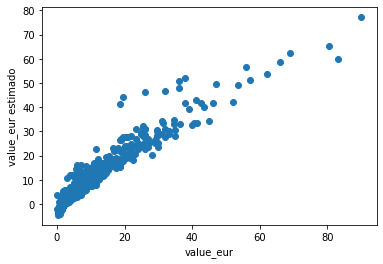

In [369]:
plt.scatter(Y_test, pred_plus)
plt.xlabel("value_eur")
plt.ylabel("value_eur estimado")
None

Se observa que hay la tendencia a una línea recta de pendiente casi 1, lo cual muestra que la predicción es  buena.

In [370]:
print('Mean Absolute Error (MAE):', mean_absolute_error(Y_test, pred_plus))
print('Mean Squared Error (MSE):', mean_squared_error(Y_test, pred_plus))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(Y_test, pred_plus)))

Mean Absolute Error (MAE): 1.3890261317152401
Mean Squared Error (MSE): 5.435229376963969
Root Mean Squared Error (RMSE): 2.331357839750039


Se observa una clara mejora de las métricas del modelo. Por ejemplo, el error absoluto medio (MAE) se ha reducido a 1.39M€.

In [371]:
r2 = r2_score(Y_test, pred_plus)
r2

0.9180477988280882

**Hay una clara mejora con el nuevo modelo**. R cuadrado pasa de 0.85 a 0.92, con lo cual podemos afirmar que nuestro modelo se ajusta bastante bien. El 91.8% de la variación de la variable dependiente (value_eur = precio del jugador) es explicada por el modelo.

In [372]:
pearson_coef, p_value = stats.pearsonr(Y_test, pred_plus)
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value)

Pearson Correlation Coefficient:  0.9594035805621718 and a P-value of: 0.0


Se confirma la mejora con el coeficiente de correlación de Pearson que pasa de 0.93 a 0.96 y P-value = 0

He probado incluso un tercer modelo incluyendo las variables age^2 o wage_eur^2, pero no se mejora el resultado.

Por tanto, **el nuevo modelo linear_reg_plus será nuestro modelo final**. 

# **Parte 2 - Clasificación con Logistic regression.**

El objetivo en este caso será clasificar un jugador según su rango de precio (value_eur), creando para ello una nueva variable (categoría) **nivel_precio**. <br>
Suponiendo que somos un inversor nos interesa clasificar los jugadores al menos en tres categorías: precio bajo (que no requiere un estudio previo), precio medio (que requiere un análisis) y precio alto (que requiere ya un estudio más detallado)

Partiendo del dataframe df_fifa inicial, creamos un dataframe df_fifa_log con una nueva variable (categoría) nivel de precio a partir de value_eur: bajo (0-5 M€), medio (5-20 M€) y alto (>20 M€). <br>
Ya no usaremos la variable value_eur y la nueva variable nivel_precio será el target de la logistic regression.

In [373]:
df_fifa_log = df_fifa.copy()

In [374]:
def nivel_precio(valor):
  if valor < 5:
    return 0
  elif valor < 20:
    return 1
  else:
    return 2 

In [375]:
df_fifa_log['nivel_precio'] = df_fifa_log['value_eur'].map(nivel_precio)

Vemos la distribución de jugadores por categoria de nivel_precio. La mayoría están lógicamente en las categorías 0 (bajo) y 1 (medio-bajo).

In [376]:
df_fifa_log.groupby(['nivel_precio'], as_index=True)['nivel_precio'].count()

nivel_precio
0    3135
1    2085
2     322
Name: nivel_precio, dtype: int64

In [377]:
df_fifa_log.head()

,short_name,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur,value_eur,nivel_precio
0,L. Messi,94,32,94,1,5,27,565.0,95.5,2
1,Cristiano Ronaldo,93,34,93,0,5,26,405.0,58.5,2
2,Neymar Jr,92,27,92,0,5,20,290.0,105.5,2
3,J. Oblak,91,26,93,0,3,12,125.0,77.5,2
4,E. Hazard,91,28,91,0,4,26,470.0,90.0,2


### **REGRESIÓN LOGÍSTICA**

In [378]:
# Creamos la variable predictora 'Xlog' y la variable target 'Ylog'
# Xlog contiene todas las caracteristicas excepto short_name, value_eur y nivel_precio 
Xlog = df_fifa_log.drop(['short_name', 'value_eur', 'nivel_precio'], axis = 1)
Ylog = df_fifa_log['nivel_precio']

In [379]:
print(Xlog.shape)
print(Ylog.shape)

(5542, 7)
(5542,)


In [380]:
# Scaling features for logistic regression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xlog[Xlog.columns] = scaler.fit_transform(Xlog[Xlog.columns])

In [381]:
Xlog_train, Xlog_test, Ylog_train, Ylog_test = train_test_split(Xlog,
                                                    Ylog, 
                                                    test_size=0.3,
                                                    random_state=0)

# Xlog_train con el 70% de los datos
print(Xlog_train.shape)
# Xlog_test contains 30% de los datos
print(Xlog_test.shape)

(3879, 7)
(1663, 7)


In [382]:
Xlog_train.head()

,overall,age,potential,preferred_foot,international_reputation,team_position,wage_eur
4514,0.041667,0.80,0.04,0.0,0.00,0.428571,0.007092
5597,0.000000,0.52,0.00,1.0,0.00,0.178571,0.008865
774,0.333333,0.24,0.56,0.0,0.25,0.321429,0.040780
1723,0.208333,0.32,0.40,0.0,0.00,0.142857,0.035461
1052,0.291667,0.28,0.48,0.0,0.25,0.535714,0.078014


**Creating and training model (logistic regression)**

In [383]:
from sklearn.linear_model import LogisticRegression

In [384]:
logisticRegr = LogisticRegression(max_iter = 1000)

In [385]:
logisticRegr.fit(Xlog_train, Ylog_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [386]:
predictions = logisticRegr.predict(Xlog_test)

In [387]:
score = logisticRegr.score(Xlog_test, Ylog_test)
score

0.920625375826819

In [388]:
# confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(Ylog_test, predictions)
print(cm)

[[917  25   0]
 [ 72 549   5]
 [  0  30  65]]


El modelo tiene un accuracy de 0.92, que es un valor bastante bueno. El acierto es especialmente alto para las categorías 0 (0-5M€) y 1 (5-20M€) que son las mayoritarias. En ningún caso un jugador es asignado a una categoría que no sea la correcta o al menos una adyacente.

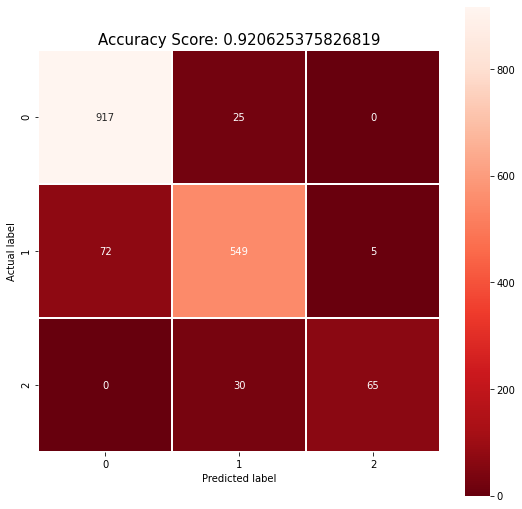

In [389]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, 
            fmt=".0f", 
            linewidths=.5, 
            square = True, 
            cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);